In [103]:
# IMPORTS
# data science libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# loading linear algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# tree based algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
# from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# machine learning processing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [104]:
# pandas display options
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

In [105]:
train_df = pd.read_csv('Resources/2019loans.csv')
test_df = pd.read_csv('Resources/2020Q1loans.csv')

# target = loan_status

In [106]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12180 entries, 0 to 12179
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  12180 non-null  int64  
 1   index                       12180 non-null  int64  
 2   loan_amnt                   12180 non-null  float64
 3   int_rate                    12180 non-null  float64
 4   installment                 12180 non-null  float64
 5   home_ownership              12180 non-null  object 
 6   annual_inc                  12180 non-null  float64
 7   verification_status         12180 non-null  object 
 8   loan_status                 12180 non-null  object 
 9   pymnt_plan                  12180 non-null  object 
 10  dti                         12180 non-null  float64
 11  delinq_2yrs                 12180 non-null  float64
 12  inq_last_6mths              12180 non-null  float64
 13  open_acc                    121

In [107]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4702 entries, 0 to 4701
Data columns (total 86 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  4702 non-null   int64  
 1   index                       4702 non-null   int64  
 2   loan_amnt                   4702 non-null   float64
 3   int_rate                    4702 non-null   float64
 4   installment                 4702 non-null   float64
 5   home_ownership              4702 non-null   object 
 6   annual_inc                  4702 non-null   float64
 7   verification_status         4702 non-null   object 
 8   loan_status                 4702 non-null   object 
 9   pymnt_plan                  4702 non-null   object 
 10  dti                         4702 non-null   float64
 11  delinq_2yrs                 4702 non-null   float64
 12  inq_last_6mths              4702 non-null   float64
 13  open_acc                    4702 

In [108]:
# Drop first 2 columns in both DataFrames
train_df.drop(['Unnamed: 0', 'index'], axis = 1, inplace = True)
test_df.drop(['Unnamed: 0', 'index'], axis = 1, inplace = True)

# Make target into boolean
train_df['loan_status'] = [1 if x == 'high_risk' else 0 for x in train_df.loan_status]
test_df['loan_status'] = [1 if x == 'high_risk' else 0 for x in test_df.loan_status]


In [109]:
# Get categorical columns and put in dataframe
str_col = []

for col in train_df.columns:
    if (train_df[col].dtype == object) & (col != 'loan_status'):
        print(col)
        str_col.append(col)
        
df_str = train_df.loc[:, str_col]
df_str.head()

home_ownership
verification_status
pymnt_plan
initial_list_status
application_type
hardship_flag
debt_settlement_flag


,home_ownership,verification_status,pymnt_plan,initial_list_status,application_type,hardship_flag,debt_settlement_flag
0,MORTGAGE,Not Verified,n,w,Individual,N,N
1,MORTGAGE,Source Verified,n,w,Individual,N,N
2,MORTGAGE,Source Verified,n,w,Individual,N,N
3,RENT,Not Verified,n,w,Individual,N,N
4,MORTGAGE,Source Verified,n,w,Individual,N,N


In [110]:
# repeat for test data
test_str = test_df.loc[:, str_col]
test_str.head()

,home_ownership,verification_status,pymnt_plan,initial_list_status,application_type,hardship_flag,debt_settlement_flag
0,MORTGAGE,Not Verified,n,w,Individual,N,N
1,RENT,Not Verified,n,w,Individual,N,N
2,RENT,Not Verified,n,w,Individual,N,N
3,RENT,Not Verified,n,w,Individual,N,N
4,RENT,Not Verified,n,w,Individual,N,N


In [111]:
for col in df_str.columns:
    print(col)
    print(df_str[col].value_counts())
    print()

home_ownership
MORTGAGE    5800
RENT        4944
OWN         1371
ANY           65
Name: home_ownership, dtype: int64

verification_status
Not Verified       5301
Source Verified    4881
Verified           1998
Name: verification_status, dtype: int64

pymnt_plan
n    12180
Name: pymnt_plan, dtype: int64

initial_list_status
w    11158
f     1022
Name: initial_list_status, dtype: int64

application_type
Individual    10400
Joint App      1780
Name: application_type, dtype: int64

hardship_flag
N    11832
Y      348
Name: hardship_flag, dtype: int64

debt_settlement_flag
N    12175
Y        5
Name: debt_settlement_flag, dtype: int64



In [112]:
# dropping pymnt_plan and debt_settlement_flag as they will not have an affect on the model
df_str.drop(['pymnt_plan', 'debt_settlement_flag'], axis = 1, inplace = True)

In [113]:
# Label encode
df_le = df_str.loc[:, ['initial_list_status', 'application_type','hardship_flag']]
df_le['initial_list_status'] = [1 if x == 'f' else 0 for x in df_le.initial_list_status]
df_le['application_type'] = [1 if x == 'Joint App' else 0 for x in df_le.application_type]
df_le['hardship_flag'] = [1 if x == 'Y' else 0 for x in df_le.hardship_flag]

df_le.head()

,initial_list_status,application_type,hardship_flag
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [114]:
# repeat for test data
# dropping pymnt_plan and debt_settlement_flag as they will not have an affect on the model
test_str.drop(['pymnt_plan', 'debt_settlement_flag'], axis = 1, inplace = True)
# Label encode
test_le = test_str.loc[:, ['initial_list_status', 'application_type','hardship_flag']]
test_le['initial_list_status'] = [1 if x == 'f' else 0 for x in test_le.initial_list_status]
test_le['application_type'] = [1 if x == 'Joint App' else 0 for x in test_le.application_type]
test_le['hardship_flag'] = [1 if x == 'Y' else 0 for x in test_le.hardship_flag]

test_le.head()

,initial_list_status,application_type,hardship_flag
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


In [115]:
# one-hot encode categorical columns
df_oh = pd.get_dummies(df_str.loc[:, ['home_ownership', 'verification_status']])
df_oh.head()

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,0,1,0,0,1,0,0
1,0,1,0,0,0,1,0
2,0,1,0,0,0,1,0
3,0,0,0,1,1,0,0
4,0,1,0,0,0,1,0


In [116]:
# repeat for test data
# one-hot encode categorical columns
test_oh = pd.get_dummies(test_str.loc[:, ['home_ownership', 'verification_status']])
test_oh.head()

,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
0,0,1,0,0,1,0,0
1,0,0,0,1,1,0,0
2,0,0,0,1,1,0,0
3,0,0,0,1,1,0,0
4,0,0,0,1,1,0,0


In [117]:
# Get numeric columns and put in dataframe
num_col = []

for col in train_df.columns:
    if (train_df[col].dtype != object) & (col != 'loan_status'):
        print(col)
        num_col.append(col)
        
df_num = train_df.loc[:, num_col]
df_num.head()

loan_amnt
int_rate
installment
annual_inc
dti
delinq_2yrs
inq_last_6mths
open_acc
pub_rec
revol_bal
total_acc
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_amnt
collections_12_mths_ex_med
policy_code
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_act_il
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc_util
chargeoff_within_12_mths
delinq_amnt
mo_sin_old_il_acct
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
mths_since_recent_bc
mths_since_recent_inq
num_accts_ever_120_pd
num_actv_bc_tl
num_actv_rev_tl
num_bc_sats
num_bc_tl
num_il_tl
num_op_rev_tl
num_rev_accts
num_rev_tl_bal_gt_0
num_sats
num_tl_120dpd_2m
num_tl_30dpd
num_tl_90g_dpd_24m
num_tl_op_past_12m
pct_tl_nvr_dlq
percent_bc_gt_75
pub_rec_bankru

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,13375.0,0.1797,483.34,223000.0,29.99,0.0,0.0,15.0,0.0,39728.0,38.0,12804.66,12804.66,953.33,953.33,570.34,382.99,0.0,0.0,0.0,483.34,0.0,1.0,0.0,0.0,465790.0,2.0,7.0,3.0,7.0,7.0,82290.0,70.0,1.0,1.0,24683.0,69.0,60200.0,1.0,12.0,2.0,9.0,31053.0,7317.0,77.1,0.0,0.0,160.0,350.0,3.0,3.0,1.0,3.0,8.0,0.0,1.0,4.0,2.0,5.0,18.0,7.0,17.0,4.0,15.0,0.0,0.0,0.0,5.0,100.0,50.0,0.0,0.0,577150.0,122018.0,32000.0,170200.0
1,21000.0,0.1308,478.68,123000.0,11.26,2.0,0.0,16.0,0.0,9585.0,20.0,15152.97,15152.97,10037.02,10037.02,5847.03,4189.99,0.0,0.0,0.0,478.68,0.0,1.0,0.0,0.0,60769.0,0.0,2.0,0.0,1.0,17.0,18311.0,52.0,0.0,4.0,4311.0,50.0,20900.0,1.0,0.0,1.0,5.0,3798.0,6990.0,56.0,0.0,0.0,165.0,142.0,13.0,13.0,1.0,17.0,10.0,1.0,5.0,8.0,6.0,7.0,5.0,13.0,14.0,8.0,16.0,0.0,0.0,0.0,0.0,85.0,33.3,0.0,0.0,132750.0,27896.0,15900.0,35398.0
2,20000.0,0.1240,448.95,197000.0,11.28,0.0,0.0,12.0,0.0,16708.0,36.0,15724.23,15724.23,6971.52,6971.52,4275.77,2695.75,0.0,0.0,0.0,448.95,0.0,1.0,0.0,0.0,617946.0,1.0,7.0,1.0,2.0,5.0,97335.0,108.0,0.0,0.0,11026.0,98.0,25900.0,2.0,0.0,2.0,3.0,51496.0,5892.0,73.9,0.0,0.0,254.0,239.0,30.0,5.0,3.0,173.0,5.0,1.0,3.0,3.0,3.0,5.0,26.0,4.0,7.0,3.0,12.0,0.0,0.0,0.0,1.0,85.7,33.3,0.0,0.0,628160.0,114043.0,22600.0,90340.0
3,3000.0,0.1240,100.22,45000.0,18.08,0.0,0.0,12.0,1.0,8809.0,19.0,2930.77,2930.77,81.63,81.63,69.23,12.40,0.0,0.0,0.0,85.76,1.0,1.0,0.0,568.0,20761.0,2.0,4.0,2.0,2.0,8.0,11952.0,78.0,2.0,4.0,2409.0,49.0,26600.0,4.0,4.0,2.0,6.0,1730.0,13470.0,32.3,0.0,0.0,135.0,146.0,2.0,2.0,0.0,2.0,8.0,0.0,5.0,6.0,6.0,6.0,8.0,8.0,11.0,6.0,12.0,0.0,0.0,0.0,4.0,100.0,16.7,1.0,0.0,42006.0,20761.0,19900.0,15406.0
4,30000.0,0.1612,1056.49,133000.0,27.77,0.0,2.0,13.0,0.0,65420.0,51.0,20778.03,20778.03,14763.99,14763.99,9221.97,5542.02,0.0,0.0,0.0,1056.49,0.0,1.0,0.0,0.0,237839.0,2.0,3.0,1.0,3.0,5.0,43636.0,74.0,1.0,1.0,19804.0,74.0,88100.0,2.0,11.0,3.0,4.0,18295.0,18517.0,76.7,0.0,0.0,174.0,369.0,1.0,1.0,2.0,34.0,0.0,0.0,6.0,9.0,6.0,19.0,17.0,9.0,32.0,9.0,13.0,0.0,0.0,0.0,2.0,100.0,66.7,0.0,0.0,283248.0,109056.0,79500.0,58778.0


In [118]:
# repeat for test data
# Get numeric columns and put in dataframe
test_num = test_df.loc[:, num_col]
test_num.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,40000.0,0.0819,814.70,140000.0,19.75,0.0,1.0,18.0,0.0,9471.0,45.0,33249.95,33249.95,9740.00,9740.00,6750.05,2989.95,0.0,0.0,0.0,814.70,0.0,1.0,0.0,0.0,377773.0,1.0,6.0,1.0,2.0,9.0,61443.0,51.0,1.0,1.0,3218.0,26.0,86500.0,0.0,2.0,1.0,3.0,20987.0,65129.0,12.7,0.0,0.0,192.0,180.0,2.0,2.0,3.0,44.0,2.0,0.0,6.0,6.0,6.0,10.0,20.0,11.0,22.0,6.0,18.0,0.0,0.0,0.0,2.0,97.7,0.0,0.0,0.0,527975.0,70914.0,74600.0,99475.0
1,6000.0,0.1524,208.70,55000.0,11.52,2.0,0.0,8.0,0.0,1280.0,12.0,0.00,0.00,6185.59,6185.59,6000.00,185.59,0.0,0.0,0.0,5773.27,0.0,1.0,0.0,0.0,23460.0,1.0,1.0,1.0,1.0,6.0,22180.0,94.0,0.0,1.0,713.0,68.0,11000.0,1.0,1.0,3.0,2.0,2933.0,4680.0,20.7,0.0,0.0,143.0,144.0,22.0,6.0,0.0,59.0,6.0,0.0,2.0,3.0,2.0,2.0,3.0,7.0,9.0,3.0,8.0,0.0,0.0,0.0,1.0,66.7,0.0,0.0,0.0,34628.0,23460.0,5900.0,23628.0
2,3600.0,0.1695,128.27,42000.0,6.74,0.0,0.0,6.0,0.0,4757.0,6.0,0.00,0.00,3603.73,3603.73,3600.00,3.73,0.0,0.0,0.0,3607.12,0.0,1.0,0.0,0.0,19183.0,0.0,3.0,0.0,0.0,40.0,14426.0,96.0,1.0,2.0,4757.0,83.0,8100.0,0.0,0.0,2.0,2.0,3837.0,2543.0,65.2,0.0,0.0,54.0,107.0,9.0,9.0,0.0,9.0,7.0,0.0,1.0,1.0,2.0,2.0,3.0,3.0,3.0,1.0,6.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,23100.0,19183.0,7300.0,15000.0
3,20000.0,0.1524,478.33,100000.0,12.13,0.0,2.0,7.0,0.0,12731.0,21.0,17624.06,17624.06,4766.37,4766.37,2375.94,2390.43,0.0,0.0,0.0,478.33,0.0,1.0,0.0,0.0,43817.0,1.0,2.0,1.0,3.0,11.0,31086.0,86.0,3.0,3.0,5917.0,78.0,20500.0,0.0,3.0,3.0,6.0,7303.0,6496.0,52.9,0.0,0.0,132.0,290.0,4.0,4.0,0.0,7.0,5.0,0.0,2.0,4.0,3.0,8.0,8.0,5.0,12.0,4.0,7.0,0.0,0.0,0.0,4.0,100.0,50.0,0.0,0.0,56481.0,43817.0,13800.0,35981.0
4,3600.0,0.1240,120.27,50000.0,16.08,0.0,3.0,6.0,0.0,10413.0,6.0,0.00,0.00,3602.48,3602.48,3600.00,2.48,0.0,0.0,0.0,3604.96,0.0,1.0,0.0,0.0,32448.0,2.0,2.0,1.0,1.0,9.0,22035.0,88.0,2.0,2.0,5985.0,71.0,21000.0,3.0,1.0,14.0,3.0,5408.0,10587.0,49.6,0.0,0.0,40.0,159.0,3.0,3.0,0.0,3.0,3.0,0.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,6.0,0.0,0.0,0.0,3.0,100.0,25.0,0.0,0.0,45977.0,32448.0,21000.0,24977.0


In [119]:
# scale numeric data
scaler = StandardScaler().fit(df_num)
df_scale = pd.DataFrame(scaler.transform(df_num), columns=df_num.columns)
df_scale.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,-0.393112,0.736585,-0.087609,0.790279,0.309615,-0.320026,-0.695401,0.376917,-0.351986,0.979339,1.083336,-0.071368,-0.071217,-1.093789,-1.093659,-0.924224,-0.968314,-0.150981,0.0,0.0,0.053954,-0.133126,0.0,-0.009061,-0.139714,1.806319,0.785406,1.179572,2.140917,3.136183,-0.516428,0.741144,-0.020749,-0.225280,-0.669299,3.455342,0.616623,0.503602,-0.282801,3.506591,-0.132295,1.186045,1.177360,-0.430820,0.951911,-0.071082,-0.009061,0.601757,1.907460,-0.648755,-0.648350,-0.175635,-0.661807,0.131913,-0.359420,-1.167625,-0.523893,-0.989682,-0.509289,1.071847,-0.334151,0.465341,-0.525210,0.379269,0.0,-0.009061,-0.148869,1.326667,0.617581,0.500053,-0.351986,0.0,1.965731,1.010651,0.156409,2.188821
1,0.351681,-0.191716,-0.103427,0.196561,-0.473994,2.170653,-0.695401,0.539402,-0.351986,-0.354346,-0.350335,0.195949,0.196078,0.736269,0.736426,0.511144,0.847978,-0.150981,0.0,0.0,0.048334,-0.133126,0.0,-0.009061,-0.139714,-0.551749,-0.871517,-0.435953,-0.881145,-0.610564,0.220799,-0.507964,-0.832495,-0.862659,0.453420,-0.332941,-0.422608,-0.500258,-0.282801,-0.578497,-0.534629,-0.015813,-0.624212,-0.448260,0.199035,-0.071082,-0.009061,0.685436,-0.228403,-0.042949,1.009132,-0.175635,-0.194150,0.467448,0.323961,0.397217,0.610258,0.222235,-0.072617,-0.589139,0.832750,0.090251,0.608016,0.541807,0.0,-0.009061,-0.148869,-1.188713,-1.069844,0.007255,-0.351986,0.0,-0.344265,-0.585044,-0.479179,-0.399905
2,0.254003,-0.320805,-0.204342,0.635913,-0.473157,-0.320026,-0.695401,-0.110538,-0.351986,-0.039187,0.924039,0.260977,0.261102,0.118673,0.118822,0.083729,0.135087,-0.150981,0.0,0.0,0.012484,-0.133126,0.0,-0.009061,-0.139714,2.692184,-0.043055,1.179572,0.126209,0.013894,-0.663873,1.034879,1.692938,-0.862659,-1.043538,0.915749,2.202816,-0.372541,0.342678,-0.578497,-0.132295,-0.616742,2.528656,-0.506821,0.837731,-0.071082,-0.009061,2.174926,0.767648,0.986922,-0.316854,1.018135,5.016891,-0.371388,0.323961,-0.385204,-0.807431,-0.686703,-0.509289,2.093992,-0.917601,-0.784958,-0.808517,-0.108345,0.0,-0.009061,-0.148869,-0.685637,-0.991097,0.007255,-0.351986,0.0,2.230882,0.875447,-0.214679,0.655196
3,-1.406519,-0.320805,-1.388060,-0.266539,-0.188665,-0.320026,-0.695401,-0.110538,2.682121,-0.388681,-0.429984,-1.195351,-1.195107,-1.269408,-1.269280,-1.060536,-1.145120,-0.150981,0.0,0.0,-0.425476,6.485154,0.0,-0.009061,0.289225,-0.784679,0.785406,0.210257,1.133563,0.013894,-0.442705,-0.632115,0.340027,0.412098,0.453420,-0.686628,-0.477304,-0.354660,1.593635,0.783199,-0.132295,0.284652,-0.760909,-0.102659,-0.646613,-0.071082,-0.009061,0.183361,-0.187329,-0.709335,-0.814099,-0.772520,-0.695211,0.131913,-0.359420,0.397217,0.043182,0.222235,-0.290953,-0.205835,-0.139667,-0.284838,0.041403,-0.108345,0.0,-0.009061,-0.148869,0.823591,0.617581,-0.482592,2.682121,0.0,-0.815953,-0.706007,-0.321269,-0.783830
4,1.230781,0.385387,1.857873,0.255933,0.216736,-0.320026,1.759668,0.051947,-0.351986,2.1160

In [120]:
# repeat for test data
# scale numeric data
test_scaler = StandardScaler().fit(test_num)
test_scale = pd.DataFrame(test_scaler.transform(test_num), columns=test_num.columns)
test_scale.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,2.273948,-1.132822,1.061318,0.917459,-0.152842,-0.323913,0.331114,0.875022,-0.334196,-0.404119,1.646021,2.361245,2.361632,0.941216,0.941928,0.724621,1.138619,-0.051948,-0.148209,-0.173344,-0.103742,-0.108026,0.0,-0.020628,-0.168369,1.323160,-0.165061,0.939057,0.027903,-0.054977,-0.279844,0.368332,-0.935069,-0.257319,-0.685335,-0.512509,-1.715898,1.158102,-0.980418,0.112386,-0.601794,-0.652027,0.526098,2.343945,-1.309104,-0.070528,-0.015078,1.156587,0.187324,-0.682051,-0.777723,1.015974,0.714902,-0.807730,-0.335802,0.721927,0.037640,0.132550,0.477493,1.415617,0.419723,1.021165,0.033085,0.877208,-0.014585,-0.014585,-0.164647,-0.260036,0.299444,-0.976752,-0.334196,0.0,1.745527,0.146528,1.591187,0.887063
1,-1.085188,0.084801,-1.005468,-0.547639,-0.541770,2.829374,-0.778578,-0.779056,-0.334196,-0.768384,-1.011363,-0.995272,-0.995195,0.242578,0.242959,0.566119,-1.035714,-0.051948,-0.148209,-0.173344,1.106197,-0.108026,0.0,-0.020628,-0.168369,-0.745029,-0.165061,-0.792762,0.027903,-0.669001,-0.481442,-0.442191,1.035967,-0.882273,-0.685335,-0.904652,0.547107,-0.846276,-0.332502,-0.228324,0.222692,-0.951600,-0.643250,-0.600924,-1.026060,-0.070528,-0.015078,0.345850,-0.182715,0.538618,-0.061465,-0.747014,1.194221,-0.091440,-0.335802,-0.810406,-0.795866,-1.045061,-1.233930,-0.867179,-0.352019,-0.561606,-0.800307,-0.777012,-0.014585,-0.014585,-0.164647,-0.748331,-3.604666,-0.976752,-0.334196,0.0,-0.843948,-0.705592,-0.892419,-0.646997
2,-1.322303,0.380140,-1.279777,-0.771713,-0.767660,-0.323913,-0.778578,-1.109872,-0.334196,-0.613757,-1.494523,-0.995272,-0.995195,-0.264900,-0.264760,0.058948,-1.176717,-0.051948,-0.148209,-0.173344,0.577635,-0.108026,0.0,-0.020628,-0.168369,-0.769995,-0.920039,-0.100035,-0.922829,-1.283026,1.803330,-0.602260,1.127644,-0.257319,-0.303800,-0.271587,1.355323,-0.923265,-0.980418,-0.569034,-0.189551,-0.951600,-0.584699,-0.705031,0.548367,-0.070528,-0.015078,-1.126712,-0.563033,-0.254817,0.475728,-0.747014,-0.403511,0.087632,-0.335802,-1.193489,-1.351537,-1.045061,-1.233930,-0.867179,-1.123760,-1.292116,-1.355902,-1.107856,-0.014585,-0.014585,-0.164647,-0.748331,0.589104,-0.976752,-0.334196,0.0,-0.904456,-0.782393,-0.841807,-0.821505
3,0.297986,0.084801,-0.085885,0.228001,-0.512943,-0.323913,1.440806,-0.944464,-0.334196,-0.259142,-0.286622,0.783842,0.784084,-0.036377,-0.036128,-0.199721,0.673787,-0.051948,-0.148209,-0.173344,-0.185819,-0.108026,0.0,-0.020628,-0.168369,-0.626202,-0.165061,-0.446398,0.027903,0.559047,-0.145446,-0.258340,0.669263,0.992590,0.077735,-0.089996,1.085918,-0.594069,-0.980418,0.453097,0.222692,0.246692,-0.360208,-0.512455,0.113188,-0.070528,-0.015078,0.163848,1.317999,-0.559984,-0.419594,-0.747014,-0.467420,-0.270513,-0.335802,-0.810406,-0.518031,-0.750658,0.049637,-0.195769,-0.737889,-0.196351,-0.522510,-0.942434,-0.014585,-0.014585,-0.164647,0.716553,0.589104,0.530853,-0.334196,0.0,-0.729246,-0.340046,-0.606823,

In [121]:
# concat dataframes back into single frame UNSCALED

df_train_unscaled = pd.concat([df_num, df_oh, df_le], axis=1)
df_train_unscaled["loan_status"] = train_df.loan_status
df_train_unscaled.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status,application_type,hardship_flag,loan_status
0,13375.0,0.1797,483.34,223000.0,29.99,0.0,0.0,15.0,0.0,39728.0,38.0,12804.66,12804.66,953.33,953.33,570.34,382.99,0.0,0.0,0.0,483.34,0.0,1.0,0.0,0.0,465790.0,2.0,7.0,3.0,7.0,7.0,82290.0,70.0,1.0,1.0,24683.0,69.0,60200.0,1.0,12.0,2.0,9.0,31053.0,7317.0,77.1,0.0,0.0,160.0,350.0,3.0,3.0,1.0,3.0,8.0,0.0,1.0,4.0,2.0,5.0,18.0,7.0,17.0,4.0,15.0,0.0,0.0,0.0,5.0,100.0,50.0,0.0,0.0,577150.0,122018.0,32000.0,170200.0,0,1,0,0,1,0,0,0,0,0,0
1,21000.0,0.1308,478.68,123000.0,11.26,2.0,0.0,16.0,0.0,9585.0,20.0,15152.97,15152.97,10037.02,10037.02,5847.03,4189.99,0.0,0.0,0.0,478.68,0.0,1.0,0.0,0.0,60769.0,0.0,2.0,0.0,1.0,17.0,18311.0,52.0,0.0,4.0,4311.0,50.0,20900.0,1.0,0.0,1.0,5.0,3798.0,6990.0,56.0,0.0,0.0,165.0,142.0,13.0,13.0,1.0,17.0,10.0,1.0,5.0,8.0,6.0,7.0,5.0,13.0,14.0,8.0,16.0,0.0,0.0,0.0,0.0,85.0,33.3,0.0,0.0,132750.0,27896.0,15900.0,35398.0,0,1,0,0,0,1,0,0,0,0,0
2,20000.0,0.1240,448.95,197000.0,11.28,0.0,0.0,12.0,0.0,16708.0,36.0,15724.23,15724.23,6971.52,6971.52,4275.77,2695.75,0.0,0.0,0.0,448.95,0.0,1.0,0.0,0.0,617946.0,1.0,7.0,1.0,2.0,5.0,97335.0,108.0,0.0,0.0,11026.0,98.0,25900.0,2.0,0.0,2.0,3.0,51496.0,5892.0,73.9,0.0,0.0,254.0,239.0,30.0,5.0,3.0,173.0,5.0,1.0,3.0,3.0,3.0,5.0,26.0,4.0,7.0,3.0,12.0,0.0,0.0,0.0,1.0,85.7,33.3,0.0,0.0,628160.0,114043.0,22600.0,90340.0,0,1,0,0,0,1,0,0,0,0,0
3,3000.0,0.1240,100.22,45000.0,18.08,0.0,0.0,12.0,1.0,8809.0,19.0,2930.77,2930.77,81.63,81.63,69.23,12.40,0.0,0.0,0.0,85.76,1.0,1.0,0.0,568.0,20761.0,2.0,4.0,2.0,2.0,8.0,11952.0,78.0,2.0,4.0,2409.0,49.0,26600.0,4.0,4.0,2.0,6.0,1730.0,13470.0,32.3,0.0,0.0,135.0,146.0,2.0,2.0,0.0,2.0,8.0,0.0,5.0,6.0,6.0,6.0,8.0,8.0,11.0,6.0,12.0,0.0,0.0,0.0,4.0,100.0,16.7,1.0,0.0,42006.0,20761.0,19900.0,15406.0,0,0,0,1,1,0,0,0,0,0,0
4,30000.0,0.1612,1056.49,133000.0,27.77,0.0,2.0,13.0,0.0,65420.0,51.0,20778.03,20778.03,14763.99,14763.99,9221.97,5542.02,0.0,0.0,0.0,1056.49,0.0,1.0,0.0,0.0,237839.0,2.0,3.0,1.0,3.0,5.0,43636.0,74.0,1.0,1.0,19804.0,74.0,88100.0,2.0,11.0,3.0,4.0,18295.0,18517.0,76.7,0.0,0.0,174.0,369.0,1.0,1.0,2.0,34.0,0.0,0.0,6.0,9.0,6.0,19.0,17.0,9.0,32.0,9.0,13.0,0.0,0.0,0.0,2.0,100.0,66.7,0.0,0.0,283248.0,109056.0,79500.0,58778.0,0,1,0,0,0,1,0,0,0,0,0


In [122]:
# concat dataframes back into single frame SCALED

df_train = pd.concat([df_scale, df_oh, df_le], axis=1)
df_train["loan_status"] = train_df.loan_status
df_train.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status,application_type,hardship_flag,loan_status
0,-0.393112,0.736585,-0.087609,0.790279,0.309615,-0.320026,-0.695401,0.376917,-0.351986,0.979339,1.083336,-0.071368,-0.071217,-1.093789,-1.093659,-0.924224,-0.968314,-0.150981,0.0,0.0,0.053954,-0.133126,0.0,-0.009061,-0.139714,1.806319,0.785406,1.179572,2.140917,3.136183,-0.516428,0.741144,-0.020749,-0.225280,-0.669299,3.455342,0.616623,0.503602,-0.282801,3.506591,-0.132295,1.186045,1.177360,-0.430820,0.951911,-0.071082,-0.009061,0.601757,1.907460,-0.648755,-0.648350,-0.175635,-0.661807,0.131913,-0.359420,-1.167625,-0.523893,-0.989682,-0.509289,1.071847,-0.334151,0.465341,-0.525210,0.379269,0.0,-0.009061,-0.148869,1.326667,0.617581,0.500053,-0.351986,0.0,1.965731,1.010651,0.156409,2.188821,0,1,0,0,1,0,0,0,0,0,0
1,0.351681,-0.191716,-0.103427,0.196561,-0.473994,2.170653,-0.695401,0.539402,-0.351986,-0.354346,-0.350335,0.195949,0.196078,0.736269,0.736426,0.511144,0.847978,-0.150981,0.0,0.0,0.048334,-0.133126,0.0,-0.009061,-0.139714,-0.551749,-0.871517,-0.435953,-0.881145,-0.610564,0.220799,-0.507964,-0.832495,-0.862659,0.453420,-0.332941,-0.422608,-0.500258,-0.282801,-0.578497,-0.534629,-0.015813,-0.624212,-0.448260,0.199035,-0.071082,-0.009061,0.685436,-0.228403,-0.042949,1.009132,-0.175635,-0.194150,0.467448,0.323961,0.397217,0.610258,0.222235,-0.072617,-0.589139,0.832750,0.090251,0.608016,0.541807,0.0,-0.009061,-0.148869,-1.188713,-1.069844,0.007255,-0.351986,0.0,-0.344265,-0.585044,-0.479179,-0.399905,0,1,0,0,0,1,0,0,0,0,0
2,0.254003,-0.320805,-0.204342,0.635913,-0.473157,-0.320026,-0.695401,-0.110538,-0.351986,-0.039187,0.924039,0.260977,0.261102,0.118673,0.118822,0.083729,0.135087,-0.150981,0.0,0.0,0.012484,-0.133126,0.0,-0.009061,-0.139714,2.692184,-0.043055,1.179572,0.126209,0.013894,-0.663873,1.034879,1.692938,-0.862659,-1.043538,0.915749,2.202816,-0.372541,0.342678,-0.578497,-0.132295,-0.616742,2.528656,-0.506821,0.837731,-0.071082,-0.009061,2.174926,0.767648,0.986922,-0.316854,1.018135,5.016891,-0.371388,0.323961,-0.385204,-0.807431,-0.686703,-0.509289,2.093992,-0.917601,-0.784958,-0.808517,-0.108345,0.0,-0.009061,-0.148869,-0.685637,-0.991097,0.007255,-0.351986,0.0,2.230882,0.875447,-0.214679,0.655196,0,1,0,0,0,1,0,0,0,0,0
3,-1.406519,-0.320805,-1.388060,-0.266539,-0.188665,-0.320026,-0.695401,-0.110538,2.682121,-0.388681,-0.429984,-1.195351,-1.195107,-1.269408,-1.269280,-1.060536,-1.145120,-0.150981,0.0,0.0,-0.425476,6.485154,0.0,-0.009061,0.289225,-0.784679,0.785406,0.210257,1.133563,0.013894,-0.442705,-0.632115,0.340027,0.412098,0.453420,-0.686628,-0.477304,-0.354660,1.593635,0.783199,-0.132295,0.284652,-0.760909,-0.102659,-0.646613,-0.071082,-0.009061,0.183361,-0.187329,-0.709335,-0.814099,-0.772520,-0

In [123]:
# repeat for test data
# concat dataframes back into single frame UNSCALED

df_test_unscaled = pd.concat([test_num, test_oh, test_le], axis=1)
df_test_unscaled["loan_status"] = test_df.loan_status
df_test_unscaled.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status,application_type,hardship_flag,loan_status
0,40000.0,0.0819,814.70,140000.0,19.75,0.0,1.0,18.0,0.0,9471.0,45.0,33249.95,33249.95,9740.00,9740.00,6750.05,2989.95,0.0,0.0,0.0,814.70,0.0,1.0,0.0,0.0,377773.0,1.0,6.0,1.0,2.0,9.0,61443.0,51.0,1.0,1.0,3218.0,26.0,86500.0,0.0,2.0,1.0,3.0,20987.0,65129.0,12.7,0.0,0.0,192.0,180.0,2.0,2.0,3.0,44.0,2.0,0.0,6.0,6.0,6.0,10.0,20.0,11.0,22.0,6.0,18.0,0.0,0.0,0.0,2.0,97.7,0.0,0.0,0.0,527975.0,70914.0,74600.0,99475.0,0,1,0,0,1,0,0,0,0,0,0
1,6000.0,0.1524,208.70,55000.0,11.52,2.0,0.0,8.0,0.0,1280.0,12.0,0.00,0.00,6185.59,6185.59,6000.00,185.59,0.0,0.0,0.0,5773.27,0.0,1.0,0.0,0.0,23460.0,1.0,1.0,1.0,1.0,6.0,22180.0,94.0,0.0,1.0,713.0,68.0,11000.0,1.0,1.0,3.0,2.0,2933.0,4680.0,20.7,0.0,0.0,143.0,144.0,22.0,6.0,0.0,59.0,6.0,0.0,2.0,3.0,2.0,2.0,3.0,7.0,9.0,3.0,8.0,0.0,0.0,0.0,1.0,66.7,0.0,0.0,0.0,34628.0,23460.0,5900.0,23628.0,0,0,0,1,1,0,0,0,0,0,0
2,3600.0,0.1695,128.27,42000.0,6.74,0.0,0.0,6.0,0.0,4757.0,6.0,0.00,0.00,3603.73,3603.73,3600.00,3.73,0.0,0.0,0.0,3607.12,0.0,1.0,0.0,0.0,19183.0,0.0,3.0,0.0,0.0,40.0,14426.0,96.0,1.0,2.0,4757.0,83.0,8100.0,0.0,0.0,2.0,2.0,3837.0,2543.0,65.2,0.0,0.0,54.0,107.0,9.0,9.0,0.0,9.0,7.0,0.0,1.0,1.0,2.0,2.0,3.0,3.0,3.0,1.0,6.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,23100.0,19183.0,7300.0,15000.0,0,0,0,1,1,0,0,0,0,0,0
3,20000.0,0.1524,478.33,100000.0,12.13,0.0,2.0,7.0,0.0,12731.0,21.0,17624.06,17624.06,4766.37,4766.37,2375.94,2390.43,0.0,0.0,0.0,478.33,0.0,1.0,0.0,0.0,43817.0,1.0,2.0,1.0,3.0,11.0,31086.0,86.0,3.0,3.0,5917.0,78.0,20500.0,0.0,3.0,3.0,6.0,7303.0,6496.0,52.9,0.0,0.0,132.0,290.0,4.0,4.0,0.0,7.0,5.0,0.0,2.0,4.0,3.0,8.0,8.0,5.0,12.0,4.0,7.0,0.0,0.0,0.0,4.0,100.0,50.0,0.0,0.0,56481.0,43817.0,13800.0,35981.0,0,0,0,1,1,0,0,0,0,0,0
4,3600.0,0.1240,120.27,50000.0,16.08,0.0,3.0,6.0,0.0,10413.0,6.0,0.00,0.00,3602.48,3602.48,3600.00,2.48,0.0,0.0,0.0,3604.96,0.0,1.0,0.0,0.0,32448.0,2.0,2.0,1.0,1.0,9.0,22035.0,88.0,2.0,2.0,5985.0,71.0,21000.0,3.0,1.0,14.0,3.0,5408.0,10587.0,49.6,0.0,0.0,40.0,159.0,3.0,3.0,0.0,3.0,3.0,0.0,4.0,4.0,4.0,4.0,2.0,4.0,4.0,4.0,6.0,0.0,0.0,0.0,3.0,100.0,25.0,0.0,0.0,45977.0,32448.0,21000.0,24977.0,0,0,0,1,1,0,0,0,0,0,0


In [124]:
# repeat for test data
# concat dataframes back into single frame SCALED

df_test = pd.concat([test_scale, test_oh, test_le], axis=1)
df_test["loan_status"] = test_df.loan_status
df_test.head()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status,application_type,hardship_flag,loan_status
0,2.273948,-1.132822,1.061318,0.917459,-0.152842,-0.323913,0.331114,0.875022,-0.334196,-0.404119,1.646021,2.361245,2.361632,0.941216,0.941928,0.724621,1.138619,-0.051948,-0.148209,-0.173344,-0.103742,-0.108026,0.0,-0.020628,-0.168369,1.323160,-0.165061,0.939057,0.027903,-0.054977,-0.279844,0.368332,-0.935069,-0.257319,-0.685335,-0.512509,-1.715898,1.158102,-0.980418,0.112386,-0.601794,-0.652027,0.526098,2.343945,-1.309104,-0.070528,-0.015078,1.156587,0.187324,-0.682051,-0.777723,1.015974,0.714902,-0.807730,-0.335802,0.721927,0.037640,0.132550,0.477493,1.415617,0.419723,1.021165,0.033085,0.877208,-0.014585,-0.014585,-0.164647,-0.260036,0.299444,-0.976752,-0.334196,0.0,1.745527,0.146528,1.591187,0.887063,0,1,0,0,1,0,0,0,0,0,0
1,-1.085188,0.084801,-1.005468,-0.547639,-0.541770,2.829374,-0.778578,-0.779056,-0.334196,-0.768384,-1.011363,-0.995272,-0.995195,0.242578,0.242959,0.566119,-1.035714,-0.051948,-0.148209,-0.173344,1.106197,-0.108026,0.0,-0.020628,-0.168369,-0.745029,-0.165061,-0.792762,0.027903,-0.669001,-0.481442,-0.442191,1.035967,-0.882273,-0.685335,-0.904652,0.547107,-0.846276,-0.332502,-0.228324,0.222692,-0.951600,-0.643250,-0.600924,-1.026060,-0.070528,-0.015078,0.345850,-0.182715,0.538618,-0.061465,-0.747014,1.194221,-0.091440,-0.335802,-0.810406,-0.795866,-1.045061,-1.233930,-0.867179,-0.352019,-0.561606,-0.800307,-0.777012,-0.014585,-0.014585,-0.164647,-0.748331,-3.604666,-0.976752,-0.334196,0.0,-0.843948,-0.705592,-0.892419,-0.646997,0,0,0,1,1,0,0,0,0,0,0
2,-1.322303,0.380140,-1.279777,-0.771713,-0.767660,-0.323913,-0.778578,-1.109872,-0.334196,-0.613757,-1.494523,-0.995272,-0.995195,-0.264900,-0.264760,0.058948,-1.176717,-0.051948,-0.148209,-0.173344,0.577635,-0.108026,0.0,-0.020628,-0.168369,-0.769995,-0.920039,-0.100035,-0.922829,-1.283026,1.803330,-0.602260,1.127644,-0.257319,-0.303800,-0.271587,1.355323,-0.923265,-0.980418,-0.569034,-0.189551,-0.951600,-0.584699,-0.705031,0.548367,-0.070528,-0.015078,-1.126712,-0.563033,-0.254817,0.475728,-0.747014,-0.403511,0.087632,-0.335802,-1.193489,-1.351537,-1.045061,-1.233930,-0.867179,-1.123760,-1.292116,-1.355902,-1.107856,-0.014585,-0.014585,-0.164647,-0.748331,0.589104,-0.976752,-0.334196,0.0,-0.904456,-0.782393,-0.841807,-0.821505,0,0,0,1,1,0,0,0,0,0,0
3,0.297986,0.084801,-0.085885,0.228001,-0.512943,-0.323913,1.440806,-0.944464,-0.334196,-0.259142,-0.286622,0.783842,0.784084,-0.036377,-0.036128,-0.199721,0.673787,-0.051948,-0.148209,-0.173344,-0.185819,-0.108026,0.0,-0.020628,-0.168369,-0.626202,-0.165061,-0.446398,0.027903,0.559047,-0.145446,-0.258340,0.669263,0.992590,0.077735,-0.089996,1.085918,-0.594069,-0.980418,0.453097,0.222692,0.246692,-0.36020

In [126]:
# correlation
corrs = abs(df_train.corr())['loan_status'].sort_values(ascending = False)
corrs

loan_status                            1.000000
int_rate                               0.241308
total_rec_int                          0.208996
total_rec_late_fee                     0.124084
out_prncp_inv                          0.101959
out_prncp                              0.101923
installment                            0.095323
acc_open_past_24mths                   0.088339
inq_last_6mths                         0.084456
hardship_flag                          0.081807
num_tl_op_past_12m                     0.080955
mths_since_recent_inq                  0.078746
inq_last_12m                           0.078254
total_bc_limit                         0.077632
open_rv_24m                            0.074387
bc_open_to_buy                         0.072173
mo_sin_old_rev_tl_op                   0.071942
total_rec_prncp                        0.071784
open_acc_6m                            0.071759
open_rv_12m                            0.064837
mo_sin_rcnt_rev_tl_op                  0

In [127]:
# correlation unscaled
corrs = abs(df_train_unscaled.corr())['loan_status'].sort_values(ascending = False)
corrs

loan_status                            1.000000
int_rate                               0.241308
total_rec_int                          0.208996
total_rec_late_fee                     0.124084
out_prncp_inv                          0.101959
out_prncp                              0.101923
installment                            0.095323
acc_open_past_24mths                   0.088339
inq_last_6mths                         0.084456
hardship_flag                          0.081807
num_tl_op_past_12m                     0.080955
mths_since_recent_inq                  0.078746
inq_last_12m                           0.078254
total_bc_limit                         0.077632
open_rv_24m                            0.074387
bc_open_to_buy                         0.072173
mo_sin_old_rev_tl_op                   0.071942
total_rec_prncp                        0.071784
open_acc_6m                            0.071759
open_rv_12m                            0.064837
mo_sin_rcnt_rev_tl_op                  0

In [128]:
# drop columns with corr score <.01, excluding one hot encoded columns UNSCALED
df_train_unscaled.drop(['num_sats', 'open_acc',
       'num_tl_90g_dpd_24m', 'delinq_amnt', 'acc_now_delinq', 'num_tl_30dpd',
       'annual_inc', 'chargeoff_within_12_mths', 'total_il_high_credit_limit',
       'total_bal_ex_mort', 'tot_coll_amt', 'pub_rec',
       'pub_rec_bankruptcies', 'total_acc', 'num_il_tl', 'recoveries',
       'collection_recovery_fee', 'policy_code', 'num_tl_120dpd_2m',
       'tax_liens'], axis = 1, inplace = True)

df_train_unscaled.head()

,loan_amnt,int_rate,installment,dti,delinq_2yrs,inq_last_6mths,revol_bal,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status,application_type,hardship_flag,loan_status
0,13375.0,0.1797,483.34,29.99,0.0,0.0,39728.0,12804.66,12804.66,953.33,953.33,570.34,382.99,0.0,483.34,0.0,465790.0,2.0,7.0,3.0,7.0,7.0,82290.0,70.0,1.0,1.0,24683.0,69.0,60200.0,1.0,12.0,2.0,9.0,31053.0,7317.0,77.1,160.0,350.0,3.0,3.0,1.0,3.0,8.0,0.0,1.0,4.0,2.0,5.0,7.0,17.0,4.0,5.0,100.0,50.0,577150.0,32000.0,0,1,0,0,1,0,0,0,0,0,0
1,21000.0,0.1308,478.68,11.26,2.0,0.0,9585.0,15152.97,15152.97,10037.02,10037.02,5847.03,4189.99,0.0,478.68,0.0,60769.0,0.0,2.0,0.0,1.0,17.0,18311.0,52.0,0.0,4.0,4311.0,50.0,20900.0,1.0,0.0,1.0,5.0,3798.0,6990.0,56.0,165.0,142.0,13.0,13.0,1.0,17.0,10.0,1.0,5.0,8.0,6.0,7.0,13.0,14.0,8.0,0.0,85.0,33.3,132750.0,15900.0,0,1,0,0,0,1,0,0,0,0,0
2,20000.0,0.1240,448.95,11.28,0.0,0.0,16708.0,15724.23,15724.23,6971.52,6971.52,4275.77,2695.75,0.0,448.95,0.0,617946.0,1.0,7.0,1.0,2.0,5.0,97335.0,108.0,0.0,0.0,11026.0,98.0,25900.0,2.0,0.0,2.0,3.0,51496.0,5892.0,73.9,254.0,239.0,30.0,5.0,3.0,173.0,5.0,1.0,3.0,3.0,3.0,5.0,4.0,7.0,3.0,1.0,85.7,33.3,628160.0,22600.0,0,1,0,0,0,1,0,0,0,0,0
3,3000.0,0.1240,100.22,18.08,0.0,0.0,8809.0,2930.77,2930.77,81.63,81.63,69.23,12.40,0.0,85.76,1.0,20761.0,2.0,4.0,2.0,2.0,8.0,11952.0,78.0,2.0,4.0,2409.0,49.0,26600.0,4.0,4.0,2.0,6.0,1730.0,13470.0,32.3,135.0,146.0,2.0,2.0,0.0,2.0,8.0,0.0,5.0,6.0,6.0,6.0,8.0,11.0,6.0,4.0,100.0,16.7,42006.0,19900.0,0,0,0,1,1,0,0,0,0,0,0
4,30000.0,0.1612,1056.49,27.77,0.0,2.0,65420.0,20778.03,20778.03,14763.99,14763.99,9221.97,5542.02,0.0,1056.49,0.0,237839.0,2.0,3.0,1.0,3.0,5.0,43636.0,74.0,1.0,1.0,19804.0,74.0,88100.0,2.0,11.0,3.0,4.0,18295.0,18517.0,76.7,174.0,369.0,1.0,1.0,2.0,34.0,0.0,0.0,6.0,9.0,6.0,19.0,9.0,32.0,9.0,2.0,100.0,66.7,283248.0,79500.0,0,1,0,0,0,1,0,0,0,0,0


In [129]:
# repeat for test data UNSCALED
# drop columns with corr score <.01, excluding one hot encoded columns
df_test_unscaled.drop(['num_sats', 'open_acc',
       'num_tl_90g_dpd_24m', 'delinq_amnt', 'acc_now_delinq', 'num_tl_30dpd',
       'annual_inc', 'chargeoff_within_12_mths', 'total_il_high_credit_limit',
       'total_bal_ex_mort', 'tot_coll_amt', 'pub_rec',
       'pub_rec_bankruptcies', 'total_acc', 'num_il_tl', 'recoveries',
       'collection_recovery_fee', 'policy_code', 'num_tl_120dpd_2m',
       'tax_liens'], axis = 1, inplace = True)

df_test_unscaled.head()

,loan_amnt,int_rate,installment,dti,delinq_2yrs,inq_last_6mths,revol_bal,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status,application_type,hardship_flag,loan_status
0,40000.0,0.0819,814.70,19.75,0.0,1.0,9471.0,33249.95,33249.95,9740.00,9740.00,6750.05,2989.95,0.0,814.70,0.0,377773.0,1.0,6.0,1.0,2.0,9.0,61443.0,51.0,1.0,1.0,3218.0,26.0,86500.0,0.0,2.0,1.0,3.0,20987.0,65129.0,12.7,192.0,180.0,2.0,2.0,3.0,44.0,2.0,0.0,6.0,6.0,6.0,10.0,11.0,22.0,6.0,2.0,97.7,0.0,527975.0,74600.0,0,1,0,0,1,0,0,0,0,0,0
1,6000.0,0.1524,208.70,11.52,2.0,0.0,1280.0,0.00,0.00,6185.59,6185.59,6000.00,185.59,0.0,5773.27,0.0,23460.0,1.0,1.0,1.0,1.0,6.0,22180.0,94.0,0.0,1.0,713.0,68.0,11000.0,1.0,1.0,3.0,2.0,2933.0,4680.0,20.7,143.0,144.0,22.0,6.0,0.0,59.0,6.0,0.0,2.0,3.0,2.0,2.0,7.0,9.0,3.0,1.0,66.7,0.0,34628.0,5900.0,0,0,0,1,1,0,0,0,0,0,0
2,3600.0,0.1695,128.27,6.74,0.0,0.0,4757.0,0.00,0.00,3603.73,3603.73,3600.00,3.73,0.0,3607.12,0.0,19183.0,0.0,3.0,0.0,0.0,40.0,14426.0,96.0,1.0,2.0,4757.0,83.0,8100.0,0.0,0.0,2.0,2.0,3837.0,2543.0,65.2,54.0,107.0,9.0,9.0,0.0,9.0,7.0,0.0,1.0,1.0,2.0,2.0,3.0,3.0,1.0,1.0,100.0,0.0,23100.0,7300.0,0,0,0,1,1,0,0,0,0,0,0
3,20000.0,0.1524,478.33,12.13,0.0,2.0,12731.0,17624.06,17624.06,4766.37,4766.37,2375.94,2390.43,0.0,478.33,0.0,43817.0,1.0,2.0,1.0,3.0,11.0,31086.0,86.0,3.0,3.0,5917.0,78.0,20500.0,0.0,3.0,3.0,6.0,7303.0,6496.0,52.9,132.0,290.0,4.0,4.0,0.0,7.0,5.0,0.0,2.0,4.0,3.0,8.0,5.0,12.0,4.0,4.0,100.0,50.0,56481.0,13800.0,0,0,0,1,1,0,0,0,0,0,0
4,3600.0,0.1240,120.27,16.08,0.0,3.0,10413.0,0.00,0.00,3602.48,3602.48,3600.00,2.48,0.0,3604.96,0.0,32448.0,2.0,2.0,1.0,1.0,9.0,22035.0,88.0,2.0,2.0,5985.0,71.0,21000.0,3.0,1.0,14.0,3.0,5408.0,10587.0,49.6,40.0,159.0,3.0,3.0,0.0,3.0,3.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,100.0,25.0,45977.0,21000.0,0,0,0,1,1,0,0,0,0,0,0


In [130]:
# drop columns with corr score <.01, excluding one hot encoded columns
df_train.drop(['num_sats', 'open_acc',
       'num_tl_90g_dpd_24m', 'delinq_amnt', 'acc_now_delinq', 'num_tl_30dpd',
       'annual_inc', 'chargeoff_within_12_mths', 'total_il_high_credit_limit',
       'total_bal_ex_mort', 'tot_coll_amt', 'pub_rec',
       'pub_rec_bankruptcies', 'total_acc', 'num_il_tl', 'recoveries',
       'collection_recovery_fee', 'policy_code', 'num_tl_120dpd_2m',
       'tax_liens'], axis = 1, inplace = True)

df_train.head()

,loan_amnt,int_rate,installment,dti,delinq_2yrs,inq_last_6mths,revol_bal,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status,application_type,hardship_flag,loan_status
0,-0.393112,0.736585,-0.087609,0.309615,-0.320026,-0.695401,0.979339,-0.071368,-0.071217,-1.093789,-1.093659,-0.924224,-0.968314,-0.150981,0.053954,-0.133126,1.806319,0.785406,1.179572,2.140917,3.136183,-0.516428,0.741144,-0.020749,-0.225280,-0.669299,3.455342,0.616623,0.503602,-0.282801,3.506591,-0.132295,1.186045,1.177360,-0.430820,0.951911,0.601757,1.907460,-0.648755,-0.648350,-0.175635,-0.661807,0.131913,-0.359420,-1.167625,-0.523893,-0.989682,-0.509289,-0.334151,0.465341,-0.525210,1.326667,0.617581,0.500053,1.965731,0.156409,0,1,0,0,1,0,0,0,0,0,0
1,0.351681,-0.191716,-0.103427,-0.473994,2.170653,-0.695401,-0.354346,0.195949,0.196078,0.736269,0.736426,0.511144,0.847978,-0.150981,0.048334,-0.133126,-0.551749,-0.871517,-0.435953,-0.881145,-0.610564,0.220799,-0.507964,-0.832495,-0.862659,0.453420,-0.332941,-0.422608,-0.500258,-0.282801,-0.578497,-0.534629,-0.015813,-0.624212,-0.448260,0.199035,0.685436,-0.228403,-0.042949,1.009132,-0.175635,-0.194150,0.467448,0.323961,0.397217,0.610258,0.222235,-0.072617,0.832750,0.090251,0.608016,-1.188713,-1.069844,0.007255,-0.344265,-0.479179,0,1,0,0,0,1,0,0,0,0,0
2,0.254003,-0.320805,-0.204342,-0.473157,-0.320026,-0.695401,-0.039187,0.260977,0.261102,0.118673,0.118822,0.083729,0.135087,-0.150981,0.012484,-0.133126,2.692184,-0.043055,1.179572,0.126209,0.013894,-0.663873,1.034879,1.692938,-0.862659,-1.043538,0.915749,2.202816,-0.372541,0.342678,-0.578497,-0.132295,-0.616742,2.528656,-0.506821,0.837731,2.174926,0.767648,0.986922,-0.316854,1.018135,5.016891,-0.371388,0.323961,-0.385204,-0.807431,-0.686703,-0.509289,-0.917601,-0.784958,-0.808517,-0.685637,-0.991097,0.007255,2.230882,-0.214679,0,1,0,0,0,1,0,0,0,0,0
3,-1.406519,-0.320805,-1.388060,-0.188665,-0.320026,-0.695401,-0.388681,-1.195351,-1.195107,-1.269408,-1.269280,-1.060536,-1.145120,-0.150981,-0.425476,6.485154,-0.784679,0.785406,0.210257,1.133563,0.013894,-0.442705,-0.632115,0.340027,0.412098,0.453420,-0.686628,-0.477304,-0.354660,1.593635,0.783199,-0.132295,0.284652,-0.760909,-0.102659,-0.646613,0.183361,-0.187329,-0.709335,-0.814099,-0.772520,-0.695211,0.131913,-0.359420,0.397217,0.043182,0.222235,-0.290953,-0.139667,-0.284838,0.041403,0.823591,0.617581,-0.482592,-0.815953,-0.321269,0,0,0,1,1,0,0,0,0,0,0
4,1.230781,0.385387,1.857873,0.216736,-0.320026,1.759668,2.116088,0.836271,0.836348,1.688594,1.688765,1.429196,1.493022,-0.150981,0.745097,-0.133126,0.479168,0.785406,-0.112848,0.126209,0.638352,-0.663873,-0.013526,0.159639,-0.225280,-0.669299,2.548066,0.890104,1.216265,0.342678,3.166167,0.270040,-0.316277,0.334049,0.166516,0.937639,0.836058,2.102563,-0.769916,-0.979847,0.421250,0.373720,-1.210223,-0.359420,0.788427,0.893796,0.222235,2.547413,0.054816,2.340789,0.891322,-0.182561,0.617581,0.992851,0.438026,2.031592,0,1,0,0,0,1,0,0,0,0,0


In [131]:
# repeat for test data
# drop columns with corr score <.01, excluding one hot encoded columns
df_test.drop(['num_sats', 'open_acc',
       'num_tl_90g_dpd_24m', 'delinq_amnt', 'acc_now_delinq', 'num_tl_30dpd',
       'annual_inc', 'chargeoff_within_12_mths', 'total_il_high_credit_limit',
       'total_bal_ex_mort', 'tot_coll_amt', 'pub_rec',
       'pub_rec_bankruptcies', 'total_acc', 'num_il_tl', 'recoveries',
       'collection_recovery_fee', 'policy_code', 'num_tl_120dpd_2m',
       'tax_liens'], axis = 1, inplace = True)

df_test.head()

,loan_amnt,int_rate,installment,dti,delinq_2yrs,inq_last_6mths,revol_bal,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,last_pymnt_amnt,collections_12_mths_ex_med,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,tot_hi_cred_lim,total_bc_limit,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_OWN,home_ownership_RENT,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,initial_list_status,application_type,hardship_flag,loan_status
0,2.273948,-1.132822,1.061318,-0.152842,-0.323913,0.331114,-0.404119,2.361245,2.361632,0.941216,0.941928,0.724621,1.138619,-0.051948,-0.103742,-0.108026,1.323160,-0.165061,0.939057,0.027903,-0.054977,-0.279844,0.368332,-0.935069,-0.257319,-0.685335,-0.512509,-1.715898,1.158102,-0.980418,0.112386,-0.601794,-0.652027,0.526098,2.343945,-1.309104,1.156587,0.187324,-0.682051,-0.777723,1.015974,0.714902,-0.807730,-0.335802,0.721927,0.037640,0.132550,0.477493,0.419723,1.021165,0.033085,-0.260036,0.299444,-0.976752,1.745527,1.591187,0,1,0,0,1,0,0,0,0,0,0
1,-1.085188,0.084801,-1.005468,-0.541770,2.829374,-0.778578,-0.768384,-0.995272,-0.995195,0.242578,0.242959,0.566119,-1.035714,-0.051948,1.106197,-0.108026,-0.745029,-0.165061,-0.792762,0.027903,-0.669001,-0.481442,-0.442191,1.035967,-0.882273,-0.685335,-0.904652,0.547107,-0.846276,-0.332502,-0.228324,0.222692,-0.951600,-0.643250,-0.600924,-1.026060,0.345850,-0.182715,0.538618,-0.061465,-0.747014,1.194221,-0.091440,-0.335802,-0.810406,-0.795866,-1.045061,-1.233930,-0.352019,-0.561606,-0.800307,-0.748331,-3.604666,-0.976752,-0.843948,-0.892419,0,0,0,1,1,0,0,0,0,0,0
2,-1.322303,0.380140,-1.279777,-0.767660,-0.323913,-0.778578,-0.613757,-0.995272,-0.995195,-0.264900,-0.264760,0.058948,-1.176717,-0.051948,0.577635,-0.108026,-0.769995,-0.920039,-0.100035,-0.922829,-1.283026,1.803330,-0.602260,1.127644,-0.257319,-0.303800,-0.271587,1.355323,-0.923265,-0.980418,-0.569034,-0.189551,-0.951600,-0.584699,-0.705031,0.548367,-1.126712,-0.563033,-0.254817,0.475728,-0.747014,-0.403511,0.087632,-0.335802,-1.193489,-1.351537,-1.045061,-1.233930,-1.123760,-1.292116,-1.355902,-0.748331,0.589104,-0.976752,-0.904456,-0.841807,0,0,0,1,1,0,0,0,0,0,0
3,0.297986,0.084801,-0.085885,-0.512943,-0.323913,1.440806,-0.259142,0.783842,0.784084,-0.036377,-0.036128,-0.199721,0.673787,-0.051948,-0.185819,-0.108026,-0.626202,-0.165061,-0.446398,0.027903,0.559047,-0.145446,-0.258340,0.669263,0.992590,0.077735,-0.089996,1.085918,-0.594069,-0.980418,0.453097,0.222692,0.246692,-0.360208,-0.512455,0.113188,0.163848,1.317999,-0.559984,-0.419594,-0.747014,-0.467420,-0.270513,-0.335802,-0.810406,-0.518031,-0.750658,0.049637,-0.737889,-0.196351,-0.522510,0.716553,0.589104,0.530853,-0.729246,-0.606823,0,0,0,1,1,0,0,0,0,0,0
4,-1.322303,-0.405702,-1.307061,-0.326276,-0.323913,2.550498,-0.362227,-0.995272,-0.995195,-0.265146,-0.265005,0.058948,-1.177686,-0.051948,0.577108,-0.108026,-0.692565,0.589917,-0.446398,0.027903,-0.669001,-0.279844,-0.445184,0.760939,0.367636,-0.303800,-0.079351,0.708750,-0.580795,0.963331,-0.228324,4.757364,-0.652027,-0.482946,-0.313155,-0.003567,-1.358351,-0.028532,-0.621017,-0.598658,-0.747014,-0.595238,-0.628657,-0.335802,-0.044240,-0.518031,-0.456256,-0.806074,-0.930825,-1.170364,-0.522510,0.228259,0.589104,-0.222950,-0.784379,-0.346532,0,0,0,1,1,0,0,0,0,0,0


In [132]:
# Train the Logistic Regression model on the unscaled data and print the model score
X_train = df_train_unscaled.drop(["loan_status","home_ownership_ANY", "verification_status_Not Verified"], axis=1).values
y_train = df_train_unscaled["loan_status"].values

X_test = df_test_unscaled.drop(["loan_status","home_ownership_ANY", "verification_status_Not Verified"], axis=1).values
y_test = df_test_unscaled["loan_status"].values

In [133]:
def evaluateModel(model, X_train, y_train, X_test, y_test):
    # FIT THE MODEL
    model.fit(X_train, y_train)

    # EVALUATE the MODEL
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # PRINT the METRICS
    print("TRAINING SET")

    class_report_train = classification_report(y_train, train_preds)
    conf_matrix_train = confusion_matrix(y_train, train_preds)

    print(class_report_train)
    print(conf_matrix_train)

    print()

    # PRINT the METRICS
    print("Testing SET")

    class_report_test = classification_report(y_test, test_preds)
    conf_matrix_test = confusion_matrix(y_test, test_preds)

    print(class_report_test)
    print(conf_matrix_test)
    
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)

    plt.figure(figsize=(10,6))
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Test Set")
    plt.legend(loc=4)
    plt.show()
    
    return(model)

TRAINING SET
              precision    recall  f1-score   support

           0       0.63      0.72      0.68      6090
           1       0.68      0.58      0.63      6090

    accuracy                           0.65     12180
   macro avg       0.66      0.65      0.65     12180
weighted avg       0.66      0.65      0.65     12180

[[4393 1697]
 [2533 3557]]

Testing SET
              precision    recall  f1-score   support

           0       0.51      0.73      0.60      2351
           1       0.53      0.31      0.39      2351

    accuracy                           0.52      4702
   macro avg       0.52      0.52      0.50      4702
weighted avg       0.52      0.52      0.50      4702

[[1712  639]
 [1621  730]]


/Users/ebimoosa/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


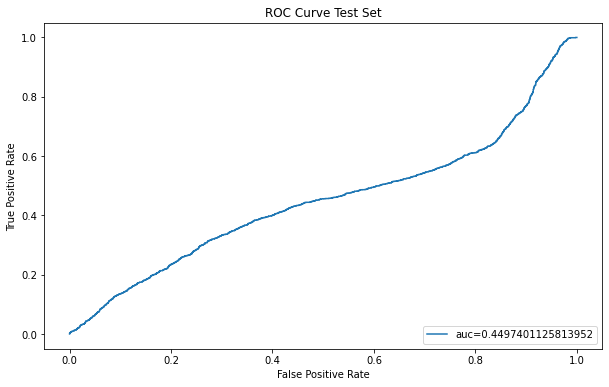

In [134]:
lr = LogisticRegression()
lr = evaluateModel(lr, X_train, y_train, X_test, y_test)

In [136]:
# Train the Logistic Regression model on the scaled data and print the model score
X_train = df_train.drop(["loan_status","home_ownership_ANY", "verification_status_Not Verified"], axis=1).values
y_train = df_train["loan_status"].values

X_test = df_test.drop(["loan_status","home_ownership_ANY", "verification_status_Not Verified"], axis=1).values
y_test = df_test["loan_status"].values

TRAINING SET
              precision    recall  f1-score   support

           0       0.69      0.75      0.72      6090
           1       0.73      0.66      0.69      6090

    accuracy                           0.71     12180
   macro avg       0.71      0.71      0.71     12180
weighted avg       0.71      0.71      0.71     12180

[[4594 1496]
 [2071 4019]]

Testing SET
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      2351
           1       0.66      0.68      0.67      2351

    accuracy                           0.67      4702
   macro avg       0.67      0.67      0.67      4702
weighted avg       0.67      0.67      0.67      4702

[[1535  816]
 [ 744 1607]]


/Users/ebimoosa/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


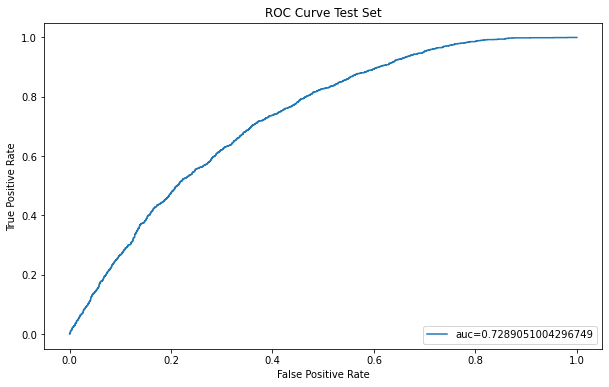

In [137]:
lr = LogisticRegression()
lr = evaluateModel(lr, X_train, y_train, X_test, y_test)

In [138]:
# Train a Random Forest Classifier model and print the model score
X_train = df_train_unscaled.drop(["loan_status"], axis=1).values
y_train = df_train_unscaled["loan_status"].values

X_test = df_test_unscaled.drop(["loan_status"], axis=1).values
y_test = df_test_unscaled["loan_status"].values

TRAINING SET
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6090
           1       1.00      1.00      1.00      6090

    accuracy                           1.00     12180
   macro avg       1.00      1.00      1.00     12180
weighted avg       1.00      1.00      1.00     12180

[[6090    0]
 [   0 6090]]

Testing SET
              precision    recall  f1-score   support

           0       0.71      0.46      0.56      2351
           1       0.60      0.81      0.69      2351

    accuracy                           0.63      4702
   macro avg       0.65      0.63      0.62      4702
weighted avg       0.65      0.63      0.62      4702

[[1075 1276]
 [ 443 1908]]


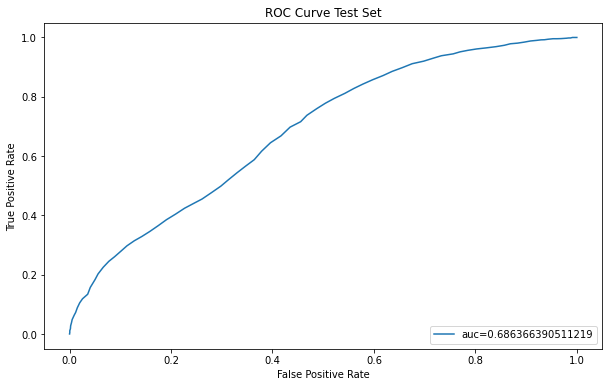

In [139]:
rf = RandomForestClassifier(random_state=42)
rf = evaluateModel(rf, X_train, y_train, X_test, y_test)

In [140]:
# Train a Random Forest Classifier model on the scaled data and print the model score
X_train = df_train.drop(["loan_status"], axis=1).values
y_train = df_train["loan_status"].values

X_test = df_test.drop(["loan_status"], axis=1).values
y_test = df_test["loan_status"].values

TRAINING SET
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6090
           1       1.00      1.00      1.00      6090

    accuracy                           1.00     12180
   macro avg       1.00      1.00      1.00     12180
weighted avg       1.00      1.00      1.00     12180

[[6090    0]
 [   0 6090]]

Testing SET
              precision    recall  f1-score   support

           0       0.77      0.20      0.32      2351
           1       0.54      0.94      0.69      2351

    accuracy                           0.57      4702
   macro avg       0.65      0.57      0.50      4702
weighted avg       0.65      0.57      0.50      4702

[[ 480 1871]
 [ 147 2204]]


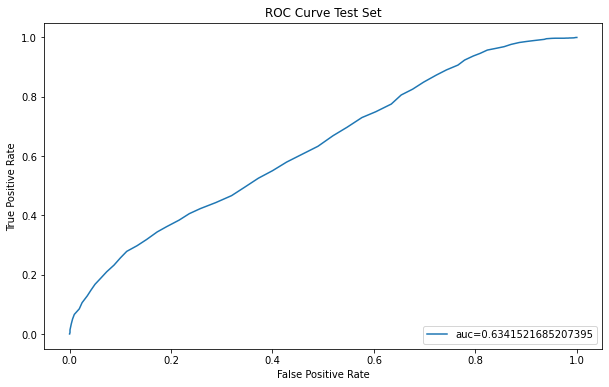

In [141]:
rf = RandomForestClassifier(random_state=42)
rf = evaluateModel(rf, X_train, y_train, X_test, y_test)